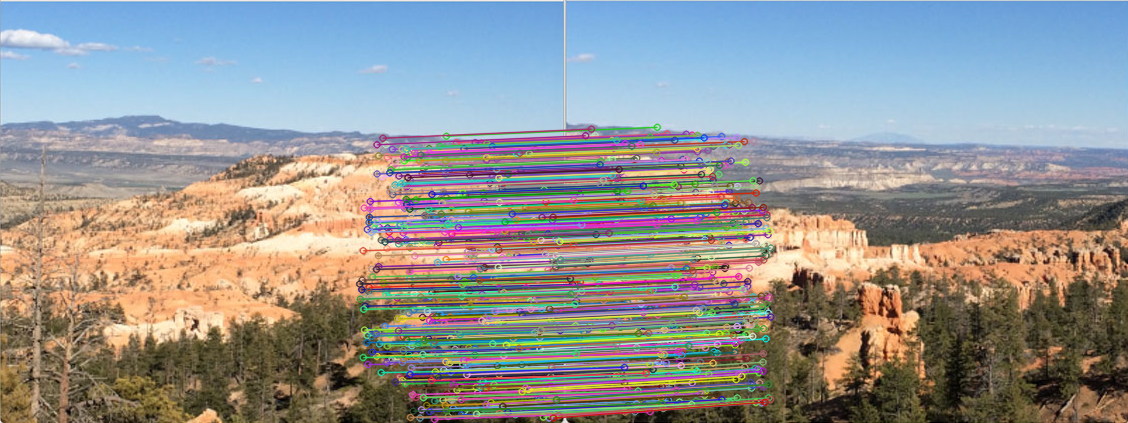

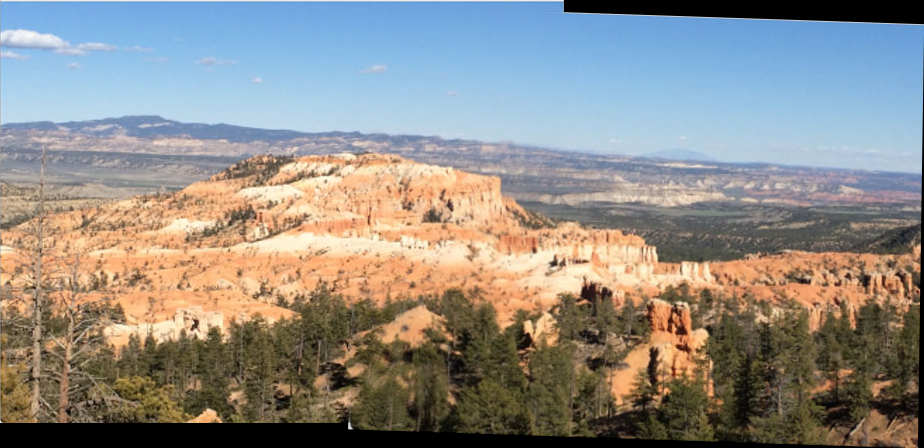

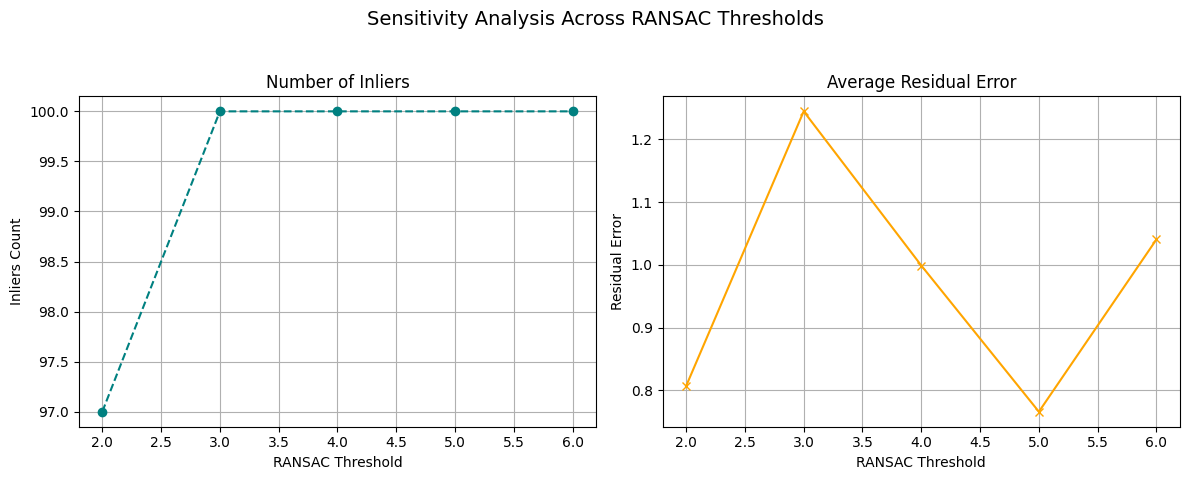

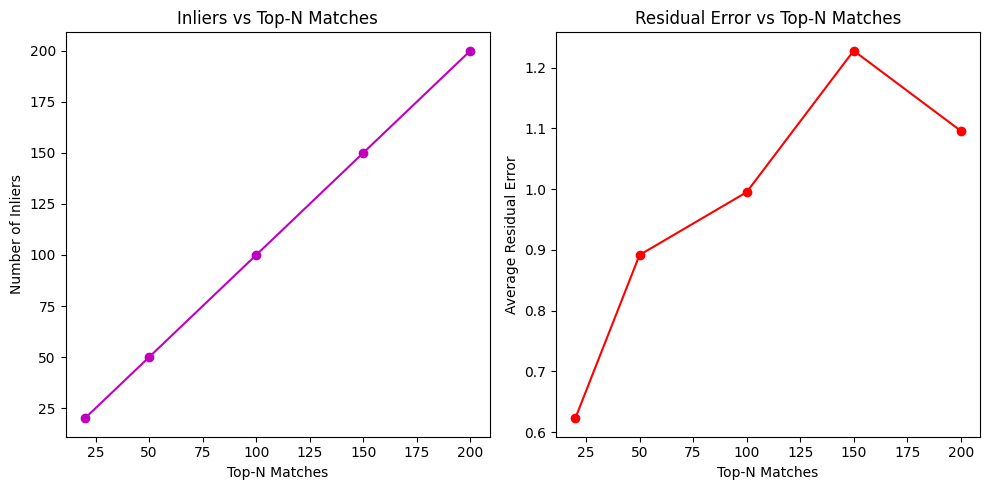

In [2]:
# user: zainab
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
# STEP 1: Harris Corner Detection + Patch Descriptor Extraction
# This function detects Harris corners and extracts fixed-size patches as descriptors.
def detect_harris_features(image, patch_size=9):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    corners = cv2.cornerHarris(gray, 2, 3, 0.04)
    corners = cv2.dilate(corners, None)

    keypoints = np.argwhere(corners > 0.01 * corners.max())
    descriptors = []
    h, w = gray.shape
    offset = patch_size // 2

    valid_keypoints = []
    for y, x in keypoints:
        if x - offset < 0 or x + offset >= w or y - offset < 0 or y + offset >= h:
            continue
        patch = gray[y - offset:y + offset + 1, x - offset:x + offset + 1].flatten()
        patch = patch.astype(np.float32)
        patch /= (np.linalg.norm(patch) + 1e-6)  # Normalize descriptor
        descriptors.append(patch)
        valid_keypoints.append(cv2.KeyPoint(float(x), float(y), patch_size))

    return valid_keypoints, np.array(descriptors)

# STEP 2: Using SIFT features (you can optionally apply on Harris points if implementing STEP 1)
def detect_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    return sift.detectAndCompute(gray, None)

# STEP 3: Matching descriptors using Euclidean distance
def match_features(desc1, desc2):
    #Euclidean distance matching (NORM_L2) and BFMatcher to find the best matches
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    return sorted(matcher.match(desc1, desc2), key=lambda m: m.distance)

def match_features_correlation(desc1, desc2, top_k=100):
    # here i did matching descriptors using Normalized Cross-Correlation manually
    corr = np.dot(desc1, desc2.T)
    norm1 = np.linalg.norm(desc1, axis=1, keepdims=True)
    norm2 = np.linalg.norm(desc2, axis=1, keepdims=True).T
    similarity = corr / (norm1 @ norm2 + 1e-6)  # Normalized cross-correlation

    matches = []
    for i in range(similarity.shape[0]):
        best_j = np.argmax(similarity[i])
        score = similarity[i][best_j]
        matches.append(cv2.DMatch(_queryIdx=i, _trainIdx=best_j, _distance=1 - score))

    matches = sorted(matches, key=lambda m: m.distance)
    return matches[:top_k]
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    return sorted(matcher.match(desc1, desc2), key=lambda m: m.distance)

# as described in step 5 estimate affine transformation using RANSAC
def estimate_affine(kp1, kp2, matches, threshold=4, iterations=1000):
    best_model, max_inliers = None, []
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    for _ in range(iterations):
        idx = random.sample(range(len(matches)), 3)
        aff = cv2.getAffineTransform(pts2[idx], pts1[idx])
        proj = cv2.transform(pts2.reshape(-1, 1, 2), aff).reshape(-1, 2)
        err = np.linalg.norm(pts1 - proj, axis=1)
        inliers = np.where(err < threshold)[0]

        if len(inliers) > len(max_inliers):
            best_model, max_inliers = aff, inliers

    return best_model, max_inliers

# Visualization of step 5 (inliers matches after RANSAC)
def draw_matches(img1, img2, kp1, kp2, matches, inliers):
    inlier_matches = [matches[i] for i in inliers]
    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches, None, flags=2)
    cv2_imshow(matched_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# blending used in step 6 (after the transformation)
def blend(img1, img2):
    mask1 = cv2.cvtColor((img1 > 0).astype(np.uint8) * 255, cv2.COLOR_BGR2GRAY)
    mask2 = cv2.cvtColor((img2 > 0).astype(np.uint8) * 255, cv2.COLOR_BGR2GRAY)
    d1 = cv2.distanceTransform(mask1, cv2.DIST_L2, 3)
    d2 = cv2.distanceTransform(mask2, cv2.DIST_L2, 3)
    total = d1 + d2 + 1e-6
    w1, w2 = d1 / total, d2 / total
    return (img1 * w1[..., None] + img2 * w2[..., None]).astype(np.uint8)

# step 6: warping image 2 into image 1 using estimated affine transform and warpAffine method
def warp_and_stitch(img1, img2, affine):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corners_img2 = np.float32([[0,0], [w2,0], [w2,h2], [0,h2]]).reshape(-1,1,2)
    transformed_corners = cv2.transform(corners_img2, affine)

    all_corners = np.concatenate((transformed_corners, np.float32([[0,0],[w1,0],[w1,h1],[0,h1]]).reshape(-1,1,2)), axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation = np.array([[1, 0, -xmin], [0, 1, -ymin]], dtype=np.float32)
    affine_with_translation = translation @ np.vstack([affine, [0, 0, 1]])
    affine_final = affine_with_translation[:2, :]

    warped_img2 = cv2.warpAffine(img2, affine_final, (xmax - xmin, ymax - ymin))

    result = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)
    result[-ymin:h1 - ymin, -xmin:w1 - xmin] = img1

    blended = blend(result, warped_img2)
    return blended

# this is step 7 where the sensitivity analysis based on RANSAC threshold has been done
def analyze_thresholds(img1, img2):
    # here if i want to switch between SIFT and Harris i can just comment the line below and uncomment the one above
    # kp1, desc1 = detect_features(img1)
    # kp2, desc2 = detect_features(img2)

    kp1, desc1 = detect_harris_features(img1, patch_size=9)
    kp2, desc2 = detect_harris_features(img2, patch_size=9)
    matches = match_features_correlation(desc1, desc2)

    thresholds = [2, 3, 4, 5, 6]
    inlier_counts = []
    residual_errors = []

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    for t in thresholds:
        affine, inliers = estimate_affine(kp1, kp2, matches, threshold=t)
        if inliers is None or len(inliers) == 0:
            inlier_counts.append(0)
            residual_errors.append(np.inf)
            continue
        proj = cv2.transform(pts2[inliers].reshape(-1, 1, 2), affine).reshape(-1, 2)
        residual = np.mean(np.linalg.norm(pts1[inliers] - proj, axis=1))
        inlier_counts.append(len(inliers))
        residual_errors.append(residual)

    # Improved and customized plot style
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Sensitivity Analysis Across RANSAC Thresholds', fontsize=14)

    axes[0].plot(thresholds, inlier_counts, marker='o', linestyle='--', color='teal')
    axes[0].set_title('Number of Inliers')
    axes[0].set_xlabel('RANSAC Threshold')
    axes[0].set_ylabel('Inliers Count')
    axes[0].grid(True)

    axes[1].plot(thresholds, residual_errors, marker='x', linestyle='-', color='orange')
    axes[1].set_title('Average Residual Error')
    axes[1].set_xlabel('RANSAC Threshold')
    axes[1].set_ylabel('Residual Error')
    axes[1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
# step 4: Sensitivity analysis by varying top-N matches
# matches based on a threshold or by considering the top few hundred pairs
def analyze_top_n_matches(img1, img2):
        # Using Harris features instead of SIFT for stitching
    kp1, desc1 = detect_harris_features(img1, patch_size=9)
    kp2, desc2 = detect_harris_features(img2, patch_size=9)
    matches_all = match_features(desc1, desc2)

    top_ns = [20, 50, 100, 150, 200]
    inliers_list = []
    residuals = []

    pts1_all = np.float32([kp1[m.queryIdx].pt for m in matches_all])
    pts2_all = np.float32([kp2[m.trainIdx].pt for m in matches_all])

    for N in top_ns:
        matches = matches_all[:N]
        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

        aff, inliers = estimate_affine(kp1, kp2, matches, threshold=4)
        if inliers is None or len(inliers) == 0:
            inliers_list.append(0)
            residuals.append(np.inf)
            continue
        proj = cv2.transform(pts2[inliers].reshape(-1, 1, 2), aff).reshape(-1, 2)
        residuals.append(np.mean(np.linalg.norm(pts1[inliers] - proj, axis=1)))
        inliers_list.append(len(inliers))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(top_ns, inliers_list, 'mo-')
    plt.title('Inliers vs Top-N Matches')
    plt.xlabel('Top-N Matches')
    plt.ylabel('Number of Inliers')

    plt.subplot(1, 2, 2)
    plt.plot(top_ns, residuals, 'ro-')
    plt.title('Residual Error vs Top-N Matches')
    plt.xlabel('Top-N Matches')
    plt.ylabel('Average Residual Error')

    plt.tight_layout()
    plt.savefig("topn_vs_performance.png")
    plt.show()

if __name__ == '__main__':
    # load the image paths here
    img1 = cv2.imread("leftImage.png")
    img2 = cv2.imread("rightImage.png")
    if img1 is None or img2 is None:
        raise Exception("Images not found")

    kp1, desc1 = detect_features(img1)
    kp2, desc2 = detect_features(img2)
    matches = match_features(desc1, desc2)

    affine, inliers = estimate_affine(kp1, kp2, matches)
    if affine is not None:
        result = warp_and_stitch(img1, img2, affine)
        draw_matches(img1, img2, kp1, kp2, matches, inliers)
        cv2_imshow(result)


    analyze_thresholds(img1, img2)
    analyze_top_n_matches(img1, img2)
